In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy.fft import ifft
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
from scipy.stats import uniform, cumfreq

In [3]:
# Load dataset from new csv file
ds_new = pd.read_csv('MB_meteorite_data.csv', delimiter='|')
print(ds_new.head())

# Drop nan values in Long and Lat
ds_new = ds_new.dropna(subset=['Lat', 'Long'])

# Split dataset into fallen and found meteorites
fallen = ds_new[ds_new['Fall'] == 'Fell']
found = ds_new[ds_new['Fall'] == 'Found']

                 Name    Status   Fall  Year  Country  \
0      Denader 001 **  Official  Found  2022     Mali   
1  Hassi Khebi 001 **  Official  Found  2022  Algeria   
2            Qaen 001  Official  Found  2016     Iran   
3           Aachen **  Official   Fell  1880  Germany   
4           Aammiq **  Official  Found  2000  Lebanon   

                          Place  Mass (g)             Type      Long  \
0                     Gao, Mali    5330.0  H4-melt breccia  -5.09405   
1              Tindouf, Algeria     500.0           C3-ung  -4.92869   
2                Khorasan, Iran   21000.0               L6  59.71863   
3  Nordrhein-Westfalen, Germany      21.0               L5   6.08333   
4             Al Biqa', Lebanon     596.0               H6  35.83333   

        Lat           GeoLocation  
0  20.71312  20.713120, -5.094050  
1  29.15786  29.157860, -4.928690  
2  33.23795  33.237950, 59.718630  
3  50.77500   50.775000, 6.083330  
4  33.70000  33.700000, 35.833330  


In [4]:
# Load dataset from old csv file
ds_old = pd.read_csv('Meteorite_Landings.csv')
print(ds_old.head())

# Drop nan values in Long and Lat
ds_old = ds_old.dropna(subset=['reclat', 'reclong'])

# Split dataset into fallen and found meteorites
fallen_old = ds_old[ds_old['fall'] == 'Fell']
found_old = ds_old[ds_old['fall'] == 'Found']

       name   id nametype     recclass  mass (g)  fall    year    reclat  \
0    Aachen    1    Valid           L5      21.0  Fell  1880.0  50.77500   
1    Aarhus    2    Valid           H6     720.0  Fell  1951.0  56.18333   
2      Abee    6    Valid          EH4  107000.0  Fell  1952.0  54.21667   
3  Acapulco   10    Valid  Acapulcoite    1914.0  Fell  1976.0  16.88333   
4   Achiras  370    Valid           L6     780.0  Fell  1902.0 -33.16667   

     reclong           GeoLocation  
0    6.08333     (50.775, 6.08333)  
1   10.23333  (56.18333, 10.23333)  
2 -113.00000    (54.21667, -113.0)  
3  -99.90000     (16.88333, -99.9)  
4  -64.95000   (-33.16667, -64.95)  


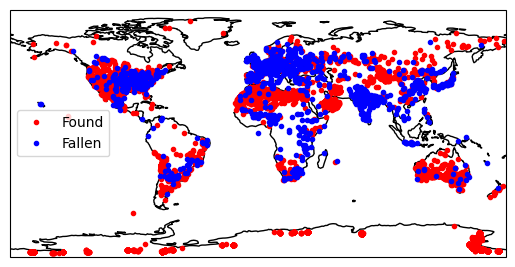

<Figure size 640x480 with 0 Axes>

In [4]:
# Prepare map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Plot meteorites on map
#map.plot(dataset['reclong'], dataset['reclat'], 'ro', markersize=3)
ax.plot(found['Long'], found['Lat'], 'ro', markersize=3, label='Found')
ax.plot(fallen_old['reclong'], fallen_old['reclat'], 'bo', markersize=3, label='Fallen')

# Show map
plt.legend()
plt.show()
plt.clf()

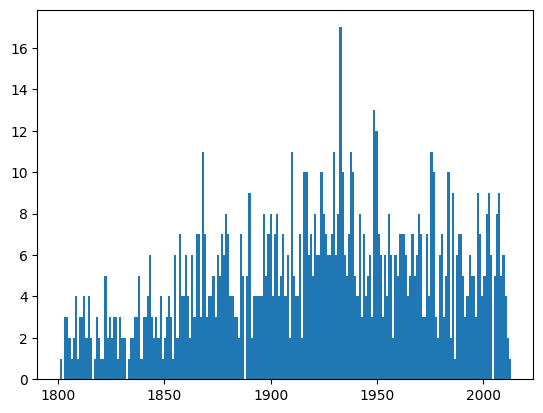

In [10]:
# Extract years
years = fallen_old['year']

# Filter years with very little data
years = years[years > 1800]
yearrange = int(years.max() - 1800) # change 1800 to years.min when using full dataset

# Create histogram
histogram = plt.hist(years, bins=yearrange)
plt.show()

In [11]:
# Extract counts from histogram
counts = histogram[0]

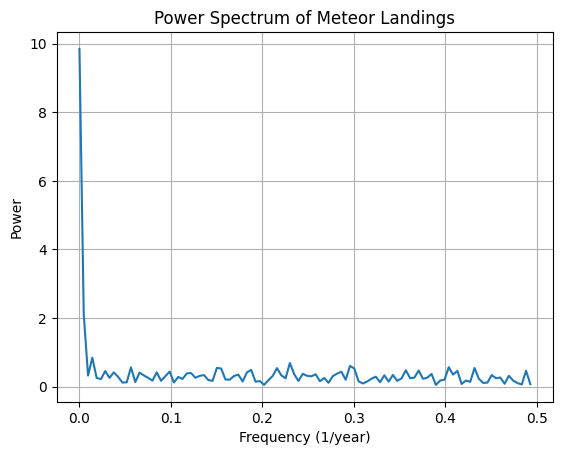

In [12]:
# Number of sample points
N = yearrange
# Sample spacing
T = 1.0  # one year

# Compute the Fast Fourier Transform (FFT)
# The FFT converts the data from the time 
# domain to the frequency domain, decomposing it into sinusoidal components at different frequencies.
yf = fft(counts)
xf = fftfreq(N, T)[:N//2]

# Compute the Power Spectrum
power_spectrum = 2.0/N * np.abs(yf[:N//2])

# Plotting the Power Spectrum
plt.plot(xf, power_spectrum)
plt.title("Power Spectrum of Meteor Landings")
plt.xlabel("Frequency (1/year)")
plt.ylabel("Power")
plt.grid()
plt.show()

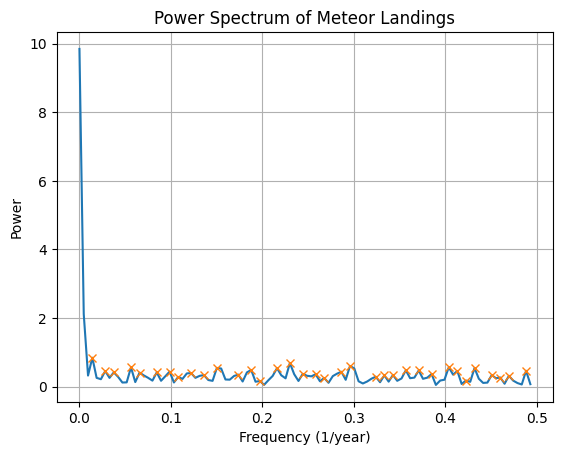

In [13]:
# Identifying Peaks
# use the find_peaks function from scipy.signal
# Find peaks
peaks, _ = find_peaks(power_spectrum, height=0.1)

# Plotting the Power Spectrum with Peaks
plt.plot(xf, power_spectrum)
plt.plot(xf[peaks], power_spectrum[peaks], "x")
plt.title("Power Spectrum of Meteor Landings")
plt.xlabel("Frequency (1/year)")
plt.ylabel("Power")
plt.grid()
plt.show()

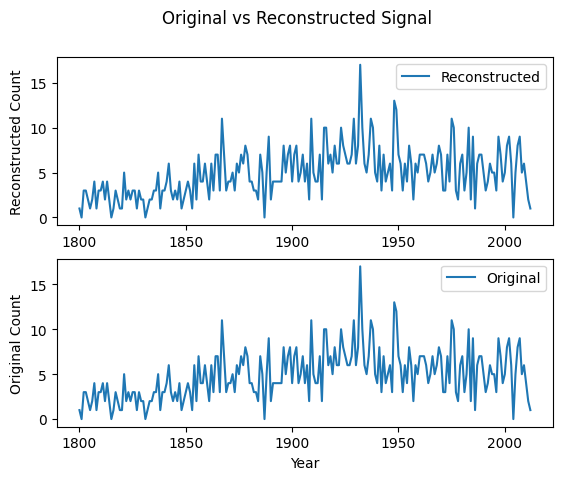

In [14]:
# Inverse Fourier Transform
time_domain_reconstructed = ifft(yf)

fig, axs = plt.subplots(2)

# Plot reconstructed signal
axs[0].plot(np.arange(1800, 1800 + len(time_domain_reconstructed.real)), time_domain_reconstructed.real, label="Reconstructed")
axs[0].set_ylabel("Reconstructed Count")
axs[0].legend()

# Plot original signal
axs[1].plot(np.arange(1800, 1800 + N), counts, label="Original", alpha=1)
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Original Count")
axs[1].legend()

plt.suptitle("Original vs Reconstructed Signal")
plt.show()

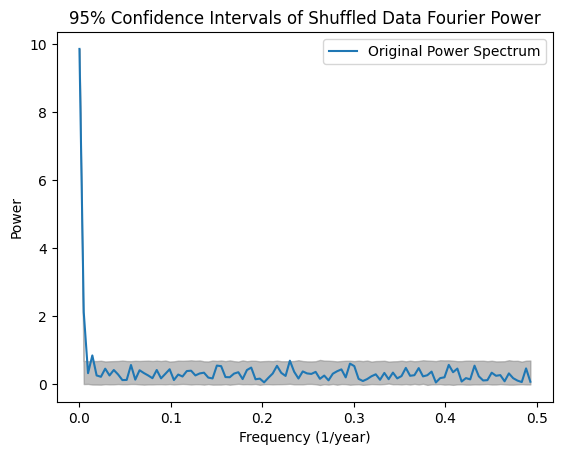

[False  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]


In [15]:
# Testing for significance
num_permutations = 1000
num_samples = len(counts)

# Store Fourier powers for each permutation
permuted_fourier_powers = np.zeros((num_permutations, num_samples // 2))

# Perform the permutations and Fourier analysis
for i in range(num_permutations):
    shuffled_counts = np.random.permutation(counts)
    fft_result_shuffle = fft(shuffled_counts)
    power = 2.0/N * np.abs(fft_result_shuffle[:N//2])
    permuted_fourier_powers[i, :] = power

# Calculate mean and standard deviation for each frequency component's power
mean_powers = np.mean(permuted_fourier_powers, axis=0)
std_powers = np.std(permuted_fourier_powers, axis=0)

# Calculate the 95% confidence intervals for the power
confidence_interval_95_upper = mean_powers + 1.96 * std_powers
confidence_interval_95_lower = mean_powers - 1.96 * std_powers

# Plot the original power spectrum with the confidence intervals
plt.fill_between(xf, confidence_interval_95_lower, confidence_interval_95_upper, color='gray', alpha=0.5)
plt.plot(xf, power_spectrum, label='Original Power Spectrum')
plt.legend()
plt.xlabel('Frequency (1/year)')
plt.ylabel('Power')
plt.title('95% Confidence Intervals of Shuffled Data Fourier Power')
plt.show()

# Identify significant peaks
significant_peaks = power_spectrum > confidence_interval_95_upper
if significant_peaks.any(): 
    print(significant_peaks)
else:
    print("No significant peaks found.")

# The results show that there are four significant peaks in the power spectrum, but that is neglectable.

In [17]:
# Extract Lat and Long for found and fallen meteorites
lat_found = found['Lat']
long_found = found['Long']
lat_fallen = fallen['Lat']
long_fallen = fallen['Long']
lat_fallen_old = fallen_old['reclat']
long_fallen_old = fallen_old['reclong']

KS Statistic: 0.1644774794763701, P-Value: 0.0


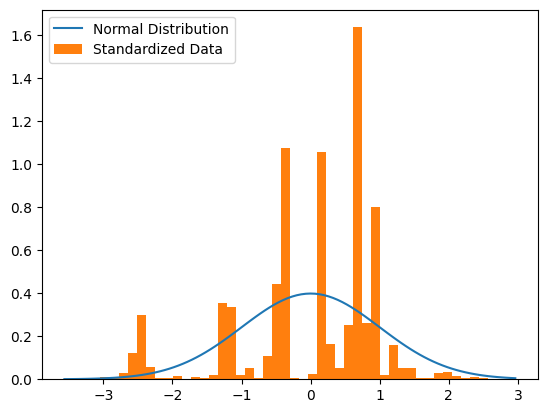

In [18]:
def haversine(lat1, lon1, lat2, lon2):
    
    # Calculate the great circle distance in kilometers between two points 
    # on the earth (specified in decimal degrees)

    # Convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula 
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    return c * r

# reference point
ref_latitude, ref_longitude = 0, 0

distances = [haversine(ref_latitude, ref_longitude, lat, lon) for lat, lon in zip(lat_found, long_found)]

# add ep to avoid division by zero
# Calculate mean and standard deviation of 'distances'
mean_distance = np.mean(distances)
std_distance = np.std(distances)

standardized_data = [(distance - mean_distance) / std_distance for distance in distances]

# Generate a normal distribution with the same size as the meteorite data
normal_distribution = np.random.normal(0, 1, size=len(standardized_data))

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(standardized_data, normal_distribution)

print(f'KS Statistic: {ks_statistic}, P-Value: {p_value}')

x_values = np.linspace(min(standardized_data), max(standardized_data), 100)
y_values = stats.norm.pdf(x_values, 0, 1)

# plot a line of the normal distribution over the normalized data
plt.plot(x_values, y_values, label='Normal Distribution')
plt.hist(standardized_data, bins=50, density = True, label='Standardized Data')
plt.legend()
plt.show()

lat  landratio


0  -85.0   0.925334
1  -75.0   0.655693
2  -65.0   0.093650
3  -55.0   0.009188
4  -45.0   0.032247
5  -35.0   0.112175
6  -25.0   0.231537
7  -15.0   0.220766
8   -5.0   0.235444
9    5.0   0.228707
10  15.0   0.263686
11  25.0   0.377645
12  35.0   0.427399
13  45.0   0.518811
14  55.0   0.569828
15  65.0   0.712646
16  75.0   0.296525
17  85.0   0.060094



lon  landratio

      
0  -175.0   0.045740
1  -165.0   0.061081
2  -155.0   0.111033
3  -145.0   0.128238
4  -135.0   0.153409
5  -125.0   0.234222
6  -115.0   0.328145
7  -105.0   0.371085
8   -95.0   0.366712
9   -85.0   0.339029
10  -75.0   0.450235
11  -65.0   0.508394
12  -55.0   0.351325
13  -45.0   0.297146
14  -35.0   0.172011
15  -25.0   0.147343
16  -15.0   0.171506
17   -5.0   0.330937
18    5.0   0.357699
19   15.0   0.542805
20   25.0   0.637631
21   35.0   0.564992
22   45.0   0.487236
23   55.0   0.395084
24   65.0   0.377327
25   75.0   0.429677
26   85.0   0.435568
27   95.0   0.468104
28  105.0   0.514497
29  115.0   0.495488
30  125.0   0.447636
31  135.0   0.416387
32  145.0   0.368617
33  155.0   0.209887
34  165.0   0.137246
35  175.0   0.089278

[5.66603661e-17 6.45015974e-05 1.29003195e-04 ... 8.37785921e-06
 4.18892961e-06 3.67969624e-18]
KS Statistic: 0.6292433991568671, P-Value: 0.0


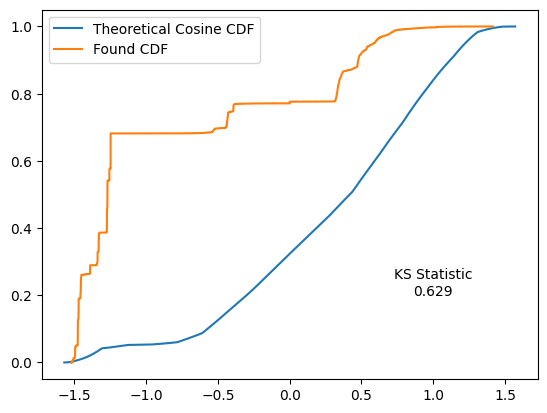

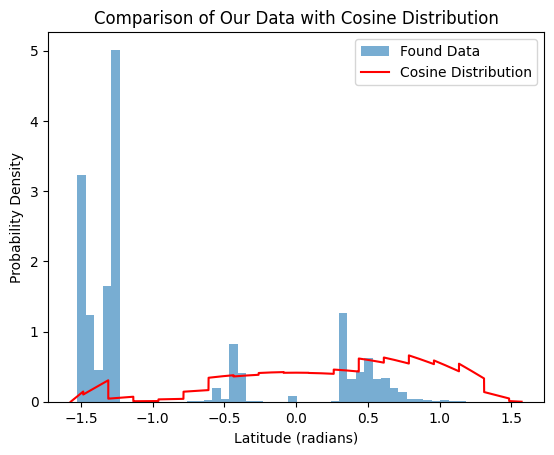

In [31]:
# Cosine found
# generate a dictionary using the lat as the key and the landratio as the value
# They are in the nearest 10, for example, if it is -90 then it is the range from -90 to -80 
# and 10 is from 0 to 10
lat_land_ratio = {-90.0: 0.925334, -80.0: 0.655693, -70.0: 0.093650, -60.0: 0.009188, -50.0: 0.032247, 
                  -40.0: 0.112175, -30.0: 0.231537, -20.0: 0.220766, -10.0: 0.235444, 0.0: 0.23, 10.0: 0.228707, 
                  20.0: 0.263686, 30.0: 0.377645, 40.0: 0.427399, 50.0: 0.518811, 60.0: 0.569828, 70.0: 0.712646,
                  80.0: 0.296525, 90.0: 0.060094}

# Forming the theoretical cosine distribution according to the latitude data
cosine_lat_theoretical = np.linspace(-np.pi/2, np.pi/2, len(lat_found))
cosine_pdf = np.cos(cosine_lat_theoretical)

# multiply the cosine_pdf by the land ratio for each latitude
for i in range(len(cosine_lat_theoretical)):
    latc = np.degrees(cosine_lat_theoretical[i])
    # Find the range that the latitude falls into
    lat_key = round(latc / 10) * 10
    cosine_pdf[i] *= lat_land_ratio[lat_key]

print(cosine_pdf)

# Turning it to cdf to compare with our data
cosine_pdf /= np.trapz(cosine_pdf, cosine_lat_theoretical) 
cosine_cdf = np.cumsum(cosine_pdf)
cosine_cdf /= cosine_cdf[-1]  

# rescaling our data to fit the distribution
rescaled_found_lat = np.radians(lat_found)  # Convert degrees to radians
ecdf_found = ECDF(rescaled_found_lat)

ks_statistic, p_value = ks_2samp(ecdf_found(cosine_lat_theoretical), cosine_cdf)
print(f"KS Statistic: {ks_statistic}, P-Value: {p_value}")

# Plotting the KS graph
plt.plot(cosine_lat_theoretical, cosine_cdf, label='Theoretical Cosine CDF')
plt.text(1, 0.2, f'KS Statistic\n{ks_statistic:.3f}', horizontalalignment='center')
plt.step(ecdf_found.x, ecdf_found.y, label='Found CDF')
plt.legend()
plt.show()

# Plotting the histogram of the (rescaled) latitude data and the 
# (not normalized) theoretical cosine distribution
plt.hist(rescaled_found_lat, bins=50, density=True, alpha=0.6, label='Found Data')
plt.plot(cosine_lat_theoretical, cosine_pdf, label='Cosine Distribution', color='red')
plt.xlabel('Latitude (radians)')
plt.ylabel('Probability Density')
plt.title('Comparison of Our Data with Cosine Distribution')
plt.legend()
plt.show()

KS Statistic: 0.2853236098450319, P-Value: 9.773769625008241e-40


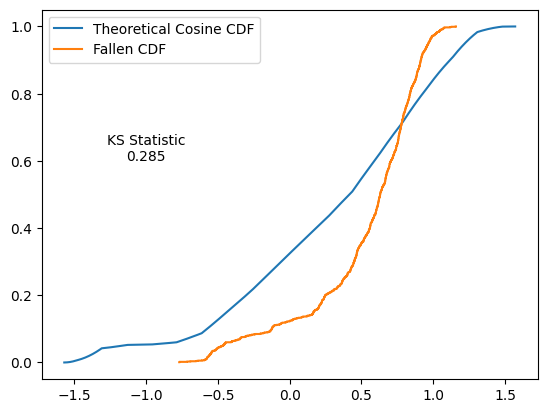

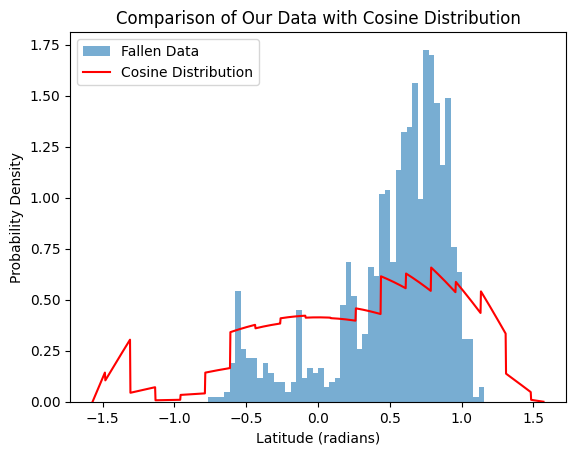

In [30]:
# cosine fall
cosine_fall_lat_theoretical = np.linspace(-np.pi/2, np.pi/2, len(lat_fallen_old))
cosine_fall_pdf = np.cos(cosine_fall_lat_theoretical)

# multiply the cosine_pdf by the land ratio for each latitude
for i in range(len(cosine_fall_lat_theoretical)):
    latc_fall = np.degrees(cosine_fall_lat_theoretical[i])
    # Find the range that the latitude falls into
    lat_key_fall = round(latc_fall / 10) * 10
    cosine_fall_pdf[i] *= lat_land_ratio[lat_key_fall]


# Turning it to cdf to compare with our data
cosine_fall_pdf /= np.trapz(cosine_fall_pdf, cosine_fall_lat_theoretical) 
cosine_fall_cdf = np.cumsum(cosine_fall_pdf)
cosine_fall_cdf /= cosine_fall_cdf[-1]

rescaled_fall_lat = np.radians(lat_fallen_old)  # Convert degrees to radians
ecdf_fall = ECDF(rescaled_fall_lat)

ks_fall_statistic, fall_p_value = ks_2samp(ecdf_fall(cosine_fall_lat_theoretical), cosine_fall_cdf)
print(f"KS Statistic: {ks_fall_statistic}, P-Value: {fall_p_value}")

# Plotting the KS graph
plt.plot(cosine_fall_lat_theoretical, cosine_fall_cdf, label='Theoretical Cosine CDF')
plt.text(-1, 0.6, f'KS Statistic\n{ks_fall_statistic:.3f}', horizontalalignment='center')
plt.step(ecdf_fall.x, ecdf_fall.y, label='Fallen CDF')
plt.legend()
plt.show()

# Plotting the histogram of the (rescaled) latitude data and the 
# (not normalized) theoretical cosine distribution
plt.hist(rescaled_fall_lat, bins=50, density=True, alpha=0.6, label='Fallen Data')
plt.plot(cosine_fall_lat_theoretical, cosine_fall_pdf, label='Cosine Distribution', color='red')
plt.xlabel('Latitude (radians)')
plt.ylabel('Probability Density')
plt.title('Comparison of Our Data with Cosine Distribution')
plt.legend()
plt.show()

KS statistic: 0.34339806117781113
P-value: 2.0778561330331306e-34


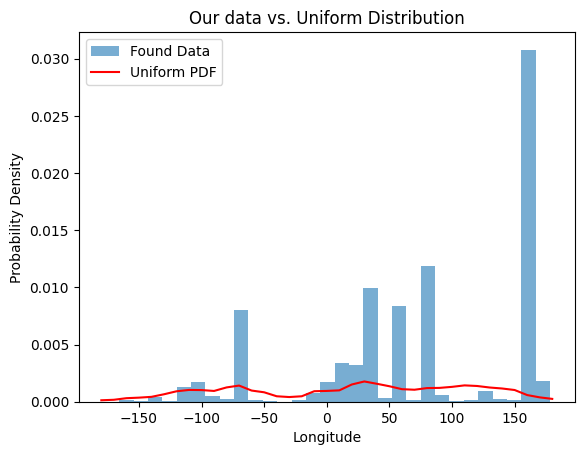

In [32]:
# Uniform found
# Generate a dictionary using the long as the key and the landratio as the value
# They are in the nearest 10, for example, if it is -180 then it is the range from -180 to -170 
# and 10 is from 0 to 10
long_landratio = {-180.0: 0.045740, -170.0: 0.061081, -160.0: 0.111033, -150.0: 0.128238,
                  -140.0: 0.153409, -130.0: 0.234222, -120.0: 0.328145, -110.0: 0.371085, 
                  -100.0: 0.366712, -90.0: 0.339029, -80.0: 0.450235, -70.0: 0.508394, 
                  -60.0: 0.351325, -50.0: 0.297146, -40.0: 0.172011, -30.0: 0.147343, -20.0: 0.171506,
                  -10.0: 0.330937, 0.00: 0.34, 10.0: 0.357699, 20.0: 0.542805, 30.0: 0.637631, 40.0: 0.564992,
                  50.0: 0.487236, 60.0: 0.395084, 70.0: 0.377327, 80.0: 0.429677, 90.0: 0.435568,
                  100.0: 0.468104, 110.0: 0.514497, 120.0: 0.495488, 130.0: 0.447636, 140.0: 0.416387,
                  150.0: 0.368617, 160.0: 0.209887, 170.0: 0.137246, 180.0: 0.089278}

longitudes = np.array(long_found) 

# multiply the uniform distribution by the land ratio for each longitude
# Define the range of your longitude data
min_long = -180
max_long = 180

# Calculate the height of the uniform PDF (flat line)
# Since it's a uniform distribution, the height is 1 divided by the range
uniform_pdf_height = 1 / (max_long - min_long)

# scale the uniform distribution by the water land ratio
scaled_values = {longitude: ratio * uniform_pdf_height for longitude, ratio in long_landratio.items()}
scaled_longitudes = []
for longitude, scaled_ratio in scaled_values.items():
    repetitions = int(scaled_ratio * 10000)
    scaled_longitudes.extend([longitude] * repetitions)

# Perform the KS test of the longitude against the uniform distribution that was multiplied to the land ratio
found_statistic, found_p_value = ks_2samp(longitudes, scaled_longitudes)

print(f"KS statistic: {found_statistic}")
print(f"P-value: {found_p_value}")

scaled_longitudes_for_plot = [scaled_values[round(long / 10) * 10] for long in np.arange(-180, 181, 10)]

plt.hist(longitudes, bins=30, density=True, alpha=0.6, label='Found Data')
plt.plot(np.arange(-180, 181, 10), scaled_longitudes_for_plot, color='r', label='Uniform PDF')
plt.xlabel('Longitude')
plt.ylabel('Probability Density')
plt.title('Our data vs. Uniform Distribution')
plt.legend()
plt.show()


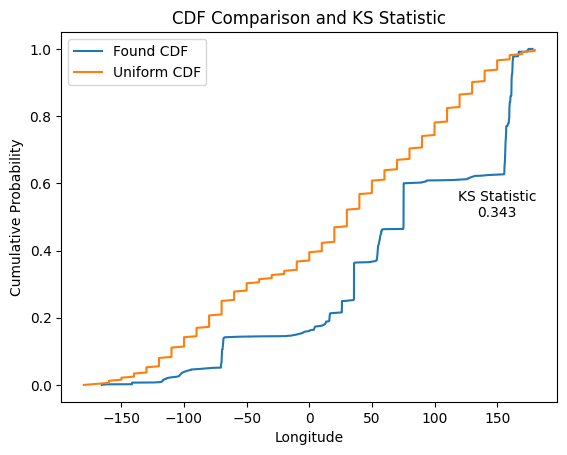

In [33]:
# Sort the data for CDF plotting
data_sorted = np.sort(longitudes)
uniform_sorted = np.sort(scaled_longitudes)

# Calculating the CDFs
cdf_data = np.arange(len(data_sorted)) / len(data_sorted)
cdf_uniform = np.arange(len(uniform_sorted)) / len(uniform_sorted)

ks_y_values = np.interp(uniform_sorted, data_sorted, cdf_data)
ks_distance = np.max(np.abs(cdf_uniform - ks_y_values))
ks_x_values = uniform_sorted[np.abs(cdf_uniform - ks_y_values) == ks_distance]

# Plotting the CDFs
plt.plot(data_sorted, cdf_data, label='Found CDF')
plt.plot(uniform_sorted, cdf_uniform, label='Uniform CDF')
plt.text(ks_x_values[0], 0.5, f'KS Statistic\n{found_statistic:.3f}', horizontalalignment='center')
plt.xlabel('Longitude')
plt.ylabel('Cumulative Probability')
plt.title('CDF Comparison and KS Statistic')
plt.legend()
plt.show()

KS statistic: 0.15159188358823728
P-value: 1.7351646231432533e-05


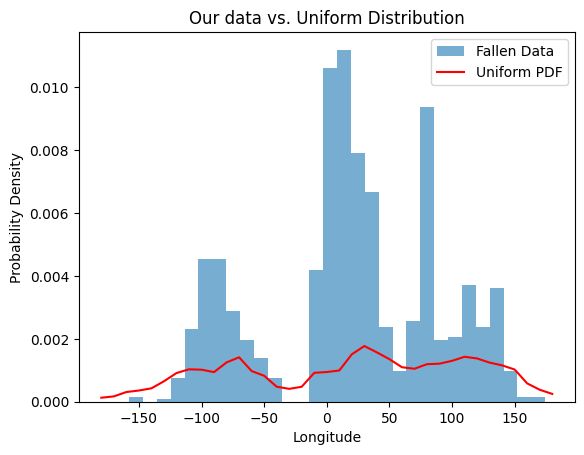

In [34]:
# For fallen meteorites

longitudes_fall = np.array(long_fallen_old) 

# Perform the KS test of the longitude against the uniform distribution that was multiplied to the land ratio
fall_long_statistic, fall_long_p_value = ks_2samp(longitudes_fall, scaled_longitudes)

print(f"KS statistic: {fall_long_statistic}")
print(f"P-value: {fall_long_p_value}")

plt.hist(longitudes_fall, bins=30, density=True, alpha=0.6, label='Fallen Data')
plt.plot(np.arange(-180, 181, 10), scaled_longitudes_for_plot, color='r', label='Uniform PDF')
plt.xlabel('Longitude')
plt.ylabel('Probability Density')
plt.title('Our data vs. Uniform Distribution')
plt.legend()
plt.show()


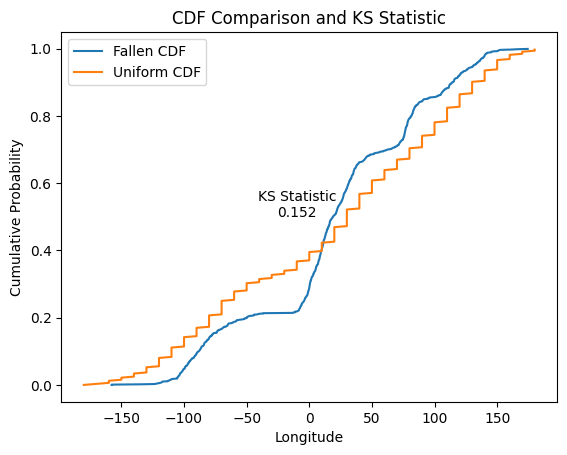

In [35]:
# Sort the data for CDF plotting
data_fall = np.sort(longitudes_fall)

# Calculating the CDFs
cdf_fall = np.arange(len(data_fall)) / len(data_fall)

ks_y_fall = np.interp(uniform_sorted, data_fall, cdf_fall)
ks_distance_fall = np.max(np.abs(cdf_uniform - ks_y_fall))
ks_x_fall = uniform_sorted[np.abs(cdf_uniform - ks_y_fall) == ks_distance_fall]

# Plotting the CDFs
plt.plot(data_fall, cdf_fall, label='Fallen CDF')
plt.plot(uniform_sorted, cdf_uniform, label='Uniform CDF')
plt.text(ks_x_fall[0], 0.5, f'KS Statistic\n{fall_long_statistic:.3f}', horizontalalignment='center')
plt.xlabel('Longitude')
plt.ylabel('Cumulative Probability')
plt.title('CDF Comparison and KS Statistic')
plt.legend()
plt.show()